In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('FIFA_train.csv',encoding = 'utf-8') # train data
test = pd.read_csv("FIFA_test.csv",encoding = 'utf-8') # test data
submission = pd.read_csv('submission.csv',encoding='utf-8')

In [3]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [4]:
train.value = np.log1p(train.value)

In [5]:
train['contract'] = 2018
test['contract'] = 2018

In [6]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [7]:
train.contract_until = train.contract_until.apply(con_period).astype('float64')
test.contract_until = test.contract_until.apply(con_period).astype('float64')

In [8]:
train.contract_until -= train.contract
test.contract_until -= test.contract 

In [9]:
train.drop('contract', axis = 1, inplace = True)
test.drop('contract', axis = 1, inplace = True)

In [10]:
train = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = train)
test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = test)

In [11]:
X = train.drop('value', axis = 1)
y = train.value

In [12]:
X[['age','reputation', 'stat_potential']] = np.log1p(X[['age','reputation', 'stat_potential']])

In [13]:
test[['age','reputation', 'stat_potential']] = np.log1p(test[['age','reputation', 'stat_potential']])

### 파생변수

In [14]:
from sklearn.decomposition import PCA

def create_new_variable(df):
    # 데이터프레임을 복사하여 새로운 데이터프레임을 생성
    new_df = df.copy()
    
#     # position별로 stat_overall과 stat_potential의 평균을 구함
#     position_stat = new_df.groupby('position')[['stat_overall', 'stat_potential']].mean()
    
#     # 기존 데이터프레임과 position_stat를 join하여 새로운 데이터프레임을 생성
#     new_df = new_df.join(position_stat.add_suffix('_mean'), on='position')
    
#     # stat_overall_dif 변수와 sod*re 변수를 생성
#     new_df['stat_overall_dif'] = new_df['stat_overall'] - new_df['stat_overall_mean']
#     new_df['sod*re'] = new_df['stat_overall_dif'] * new_df['reputation']
    
#     # stat_potential_dif 변수와 spd*re 변수를 생성
#     new_df['stat_potential_dif'] = new_df['stat_potential'] - new_df['stat_potential_mean']
#     new_df['spd*re'] = new_df['stat_potential_dif'] * new_df['reputation']
    
#     # 수학적 기법인 가중조화평균을 이용해 가중치(reputation)으로 raw data에서 상관관계가 높은 변수로 만들어봄
#     new_df['egi'] = (new_df['reputation'] ** 0.5 * (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5) / (new_df['reputation'] ** 0.5 + (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5)
    
    # 나이별 그룹을 만들어서 가중치를 두고 분석에 이용
    new_df['age_group'] = pd.cut(new_df['age'], 
                                 bins=[0, 20, 25, 30, 100], 
                                 labels=['under 20', '20-25', '26-30', 'over 30'])
    
    age_group_level_map = {
    'under 20' :    4,
    '20-25'    :    3, 
    '26-30'       :    2,
    'over 30'        :    1, 
    } 
    
    new_df['age_group_level'] = new_df['age_group'].map(age_group_level_map)
    new_df['age_group_level'] = new_df['age_group_level'].astype('float64')
#     new_df['agl*spdre'] = new_df['age_group_level'] * new_df['spd*re']
    
    # 유망주에 관한 변수 생성
    new_df['youth'] = (new_df['stat_overall'] * new_df['reputation']) / new_df['age']
    
#     # 포지션별 선수 순위를 내림차순으로 정리하는 position_rank 변수 생성
#     new_df['position_rank'] = new_df.groupby('position')['stat_overall'].rank(ascending=True)
    
#     # position_rank를 가중치인 reputation 변수와 곱해 새로운 파생변수 생성(corr=0.68)
#     new_df['position_rank*stat_potential']= new_df['position_rank'] * new_df['stat_potential']
    
    # 'reputation', 'stat_overall', 'stat_potential' 세 변수로 PCA를 수행하여 2개의 새로운 변수를 생성
    pca = PCA(n_components=2)
    new_df[['pca_1', 'pca_2']] = pca.fit_transform(new_df[['reputation', 'stat_overall', 'stat_potential']])
    
    # 'reputation', 'stat_overall', 'stat_potential' 세 변수로 PCA를 수행하여 2개의 새로운 변수를 생성
    pca = PCA(n_components=2)
    new_df[['pca_3', 'pca_4']] = pca.fit_transform(new_df[['reputation', 'youth', 'stat_potential']])

    
    # 파생변수를 선택하여 반환
    return new_df[['age_group', 'age_group_level', 'youth', 'pca_1', 'pca_2', 'pca_3', 'pca_4']]

In [15]:
train = pd.merge(train, create_new_variable(train), left_index=True, right_index=True)

<AxesSubplot:>

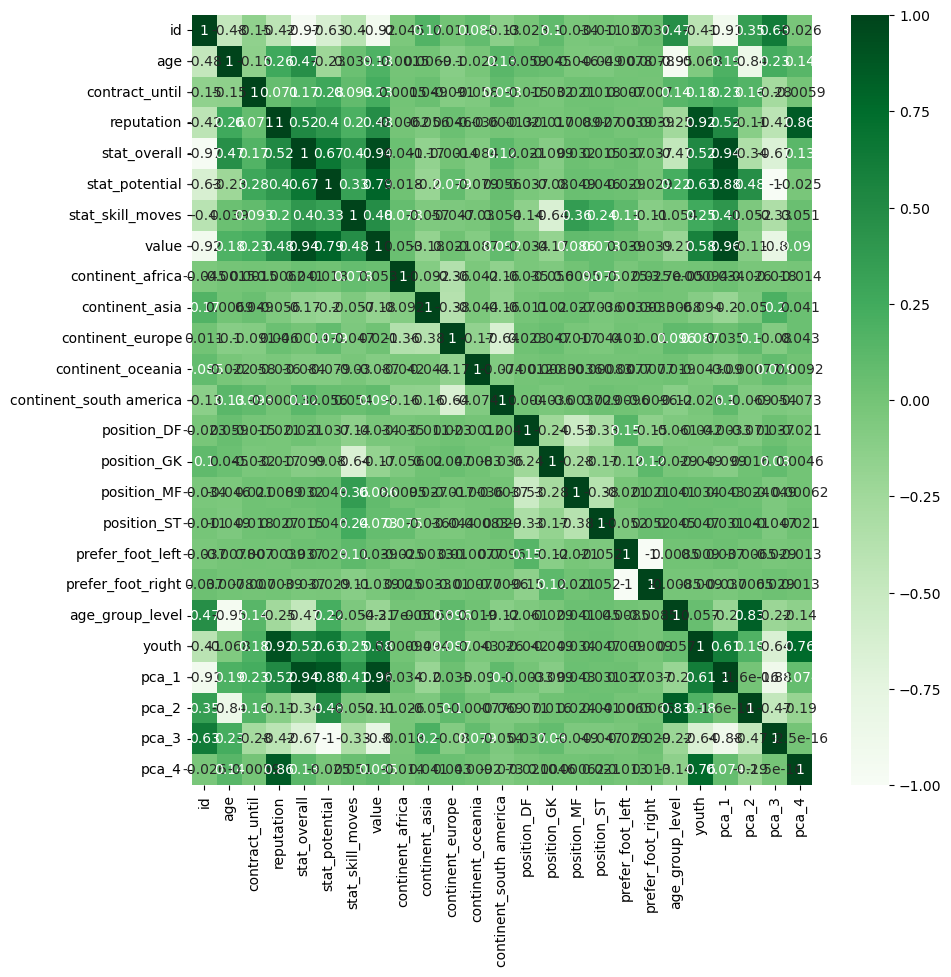

In [16]:
#heatmap으로 상관관계를 표시
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["figure.figsize"] = (10,10)
sb.heatmap(train.corr(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

In [17]:
train.head()

,id,name,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,...,position_ST,prefer_foot_left,prefer_foot_right,age_group,age_group_level,youth,pca_1,pca_2,pca_3,pca_4
0,0,L. Messi,31,3.0,5.0,94,94,4.0,18.520526,0,...,1,1,0,over 30,1.0,15.161290,34.848798,-0.016776,-23.563566,9.468881
1,3,De Gea,27,2.0,4.0,91,93,1.0,18.092177,0,...,0,0,1,26-30,2.0,13.481481,31.867455,1.118094,-22.312198,7.705944
2,7,L. Suárez,31,3.0,5.0,91,91,3.0,18.197537,0,...,1,0,1,over 30,1.0,14.677419,30.629053,-0.444209,-20.526807,9.438482
3,8,Sergio Ramos,32,2.0,4.0,91,91,3.0,17.747336,0,...,0,0,1,over 30,1.0,11.375000,30.602837,-0.431283,-20.041411,6.027592
4,9,J. Oblak,25,3.0,3.0,90,93,1.0,18.035018,0,...,0,0,1,20-25,3.0,10.800000,31.066967,1.763231,-21.912527,4.872198


In [18]:
test = pd.merge(test, create_new_variable(test), left_index=True, right_index=True)

In [19]:
test.head()

,id,name,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,...,position_ST,prefer_foot_left,prefer_foot_right,age_group,age_group_level,youth,pca_1,pca_2,pca_3,pca_4
0,1,Cristiano Ronaldo,3.526361,4.0,1.791759,94,4.553877,5.0,0,0,...,1,0,1,under 20,4.0,47.761818,26.675557,0.701045,32.171924,0.058288
1,2,Neymar Jr,3.295837,4.0,1.791759,92,4.543295,5.0,0,0,...,1,0,1,under 20,4.0,50.015179,24.675705,0.727025,34.423765,0.048157
2,4,K. De Bruyne,3.332205,5.0,1.609438,91,4.532599,4.0,0,0,...,0,0,1,under 20,4.0,43.952539,23.673379,0.557630,28.358673,0.011616
3,5,E. Hazard,3.332205,2.0,1.609438,91,4.521789,4.0,0,0,...,1,0,1,under 20,4.0,43.952539,23.673290,0.557335,28.358553,0.020771
4,6,L. Modrić,3.496508,2.0,1.609438,91,4.521789,4.0,0,0,...,0,0,1,under 20,4.0,41.887182,23.673290,0.557335,26.294482,0.038270


In [20]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# # Split features and target variable
# X = train.drop(['value', 'id', 'name'], axis=1)
# y = train["value"]

# Define the base models
models = [
    LGBMRegressor(random_state=42),
    XGBRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False),
    RandomForestRegressor(random_state=42)
]

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use pandas' select_dtypes method to select categorical and numerical features
categorical_features = X.select_dtypes(include=['object'])
numerical_features = X.select_dtypes(include=['int64', 'float64'])

# Define transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features.columns),
    ('num', numerical_transformer, numerical_features.columns)
])

# Fit and transform the preprocessing pipeline on the training set
X_preprocessed = preprocessor.fit_transform(X)

# Transform the test set using the fitted preprocessing pipeline
test_preprocessed = preprocessor.transform(test)

# Initialize empty arrays for storing the predictions on the train set
train_predictions = np.zeros((X_preprocessed.shape[0], len(models)))
test_predictions = np.zeros((test_preprocessed.shape[0], len(models)))

# Define the number of folds for cross-validation
n_splits = 5

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through the models and fit them using cross-validation
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_preprocessed, y)):
        # Split the data into training and validation sets for this fold
        train_features, train_target = X_preprocessed[train_idx], y.iloc[train_idx]
        val_features, val_target = X_preprocessed[val_idx], y.iloc[val_idx]

        # Fit the model on the training data for this fold
        model.fit(train_features, train_target)

        # Predict on the validation data for this fold
        val_predictions = model.predict(val_features)

        # Store the predictions for this fold in the train_predictions array
        train_predictions[val_idx, i] = val_predictions
        
    # Predict on the test set with the current model
    test_predictions[:, i] = model.predict(test_preprocessed)

# Scale the train and test predictions using a standard scaler
scaler = StandardScaler()
train_predictions_scaled = scaler.fit_transform(train_predictions)
test_predictions_scaled = scaler.transform(test_predictions)

# Define the meta-model
meta_model = LinearRegression()

# Fit the meta-model on the scaled train predictions
meta_model.fit(train_predictions_scaled, y)

# Predict on the scaled test predictions with the meta-model
meta_predictions = meta_model.predict(test_predictions_scaled)


# # Calculate the mean squared error of the meta-predictions on the test set
# rmse = mean_squared_error(y_test, meta_predictions)**0.5
# print(f"Meta-model RMSE on test set: {rmse:.4f}")


Training model 1
Training model 2
Training model 3
Training model 4


In [21]:
meta_predictions = np.exp(meta_predictions)
print(meta_predictions)

[4.64641477e+07 7.87384238e+07 7.76461031e+07 ... 5.62009677e+04
 4.87075729e+04 4.91189393e+04]


In [22]:
submission['value']=meta_predictions

In [23]:
submission.to_csv('submission_JH_5.csv')